# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [57]:
%pip install matplotlib
%pip install numpy

%pip install tensorflow
%pip install scikit-learn
%pip PIL

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Root\Documents\GitHub\Labs\ai-lab-m2-convolutional-networks-Nshtk\.venv\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Root\Documents\GitHub\Labs\ai-lab-m2-convolutional-networks-Nshtk\.venv\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\Root\Documents\GitHub\Labs\ai-lab-m2-convolutional-networks-Nshtk\.venv\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "PIL"



In [154]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import PIL
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn import metrics

Для визуализации списка изображений можно использовать такую функцию:

In [65]:
def display_images(dataset, classes):
	plt.figure(figsize=(10, 10))
	for images, labels in dataset.take(1):
		for i in range(9):
			plt.subplot(3, 3, i + 1)
			plt.imshow(images[i].numpy().astype(int))
			plt.title(classes[labels[i]])
			plt.axis("off")

## Бинарная классификация

### Подготовка данных

In [8]:
folder_data_initial_name="petfaces"
folder_data_name="data/faces"
folder_data_cats_name=folder_data_name+"/cats"
folder_data_dogs_name=folder_data_name+"/dogs"

if not os.path.exists("petfaces") or not os.path.exists("pets"):
	print("Датасеты Pets и Petfaces должны быть скачаны и разархивированы в директорию с ipynb файлами.")
	raise

is_copying_images=True
if not os.path.exists(folder_data_dogs_name) and not os.path.exists(folder_data_cats_name):
	os.makedirs(folder_data_cats_name)
	os.makedirs(folder_data_dogs_name)
	if(len(os.listdir(folder_data_cats_name)) or len(os.listdir(folder_data_cats_name))):
		is_copying_images=False

images_count_cats=0; images_count_dogs=0
for folder in os.scandir(folder_data_initial_name):
	folder_name = os.path.basename(folder)
	folder_files=os.listdir(folder)
	folder_images_number = len(folder_files)
	if 'cat' in folder_name:
		folder_copy_to_name=folder_data_cats_name
		images_count_cats += folder_images_number
	elif 'dog' in folder_name:
		folder_copy_to_name=folder_data_dogs_name
		images_count_dogs += folder_images_number
	if is_copying_images:
		for file in folder_files:
			shutil.copy(f"{folder_data_initial_name}/{folder_name}/{file}", folder_copy_to_name)

print("Images count: ", images_count_cats+images_count_dogs)
print("Cats images count: ", images_count_cats)
print("Dogs images count: ", images_count_dogs)

Images count: 3211
Cats images count: 1106, dogs images count: 2105


### Предварительная обработка данных

Found 3211 files belonging to 2 classes.
Using 2569 files for training.
Found 3211 files belonging to 2 classes.
Using 642 files for validation.
Training batch shape: features=(32, 128, 128, 3), labels=(32,)
Training batch shape: features=(32, 128, 128, 3), labels=(32,)


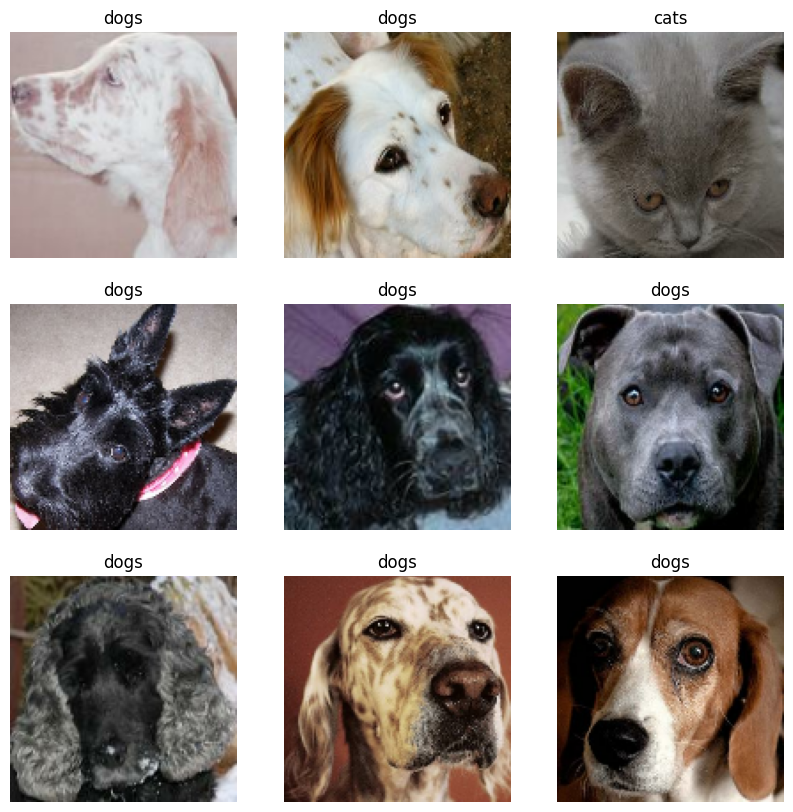

In [126]:
classes=os.listdir(folder_data_name)
image_size = (128, 128)
batch_size = 32

dataset_train = keras.utils.image_dataset_from_directory(folder_data_name, validation_split = 0.2, subset = 'training', seed = 13, image_size = image_size, batch_size = batch_size)
dataset_test = keras.utils.image_dataset_from_directory(folder_data_name, validation_split = 0.2, subset = 'validation', seed = 13, image_size = image_size, batch_size = batch_size)
display_images(dataset_train, classes)

for x, y in dataset_train:
	x_train, y_train = x, y
	print(f"Training batch shape: features={x.shape}, labels={y.shape}")
	break
for x, y in dataset_test:
	x_test, y_test = x, y
	print(f"Training batch shape: features={x.shape}, labels={y.shape}")
	break

x_test_list = []	#Used when building confusion matrix
y_test_list = []
for x, y in dataset_test:
	x_test_list.append(x)
	y_test_list.append(y)

normalization_layer = keras.layers.Rescaling(1./255)
dataset_train=dataset_train.map(lambda x, y: (normalization_layer(x), y))
dataset_test=dataset_test.map(lambda x, y: (normalization_layer(x), y))

### Создание и обучение модели

In [137]:
model=keras.models.Sequential ( 
	[
		keras.layers.Conv2D(32, (3, 3), input_shape = (image_size[0], image_size[1], 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Flatten(),
		keras.layers.Dense(512, activation='relu'),
		keras.layers.Dropout(0.5),
		keras.layers.Dense(1, activation="sigmoid")
	]
)
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,601,153 (9.92 MB)

 Trainable params: 2,601,153 (9.92 MB)

 Non-trainable params: 0 (0.00 B)

In [123]:
model.fit(dataset_train, epochs = 5, steps_per_epoch = batch_size, validation_data = dataset_test, validation_steps = batch_size)

Epoch 1/5


32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.6028 - loss: 0.6726 - val_accuracy: 0.6495 - val_loss: 0.6313
Epoch 2/5
 1/32 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7188 - loss: 0.5896

c:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.6694 - loss: 0.6293 - val_accuracy: 0.7757 - val_loss: 0.5049
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7828 - loss: 0.4765 - val_accuracy: 0.8255 - val_loss: 0.4613
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.8270 - loss: 0.4170 - val_accuracy: 0.8707 - val_loss: 0.3264
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8630 - loss: 0.3533 - val_accuracy: 0.8972 - val_loss: 0.2617


Тестирование

In [124]:
loss, accuracy = model.evaluate(dataset_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9137 - loss: 0.2699
Test loss: 0.26170459389686584
Test accuracy: 0.8971962332725525


Матрица оишибок

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


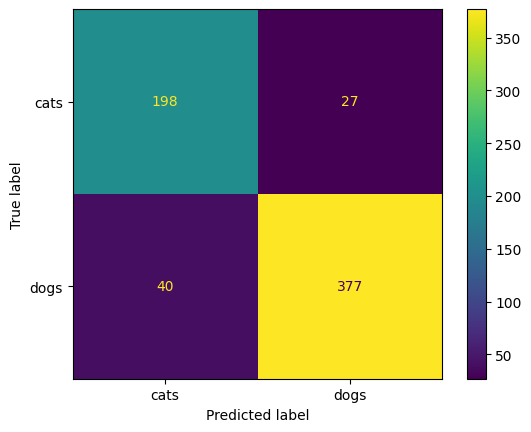

In [127]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(np.concatenate(y_test_list), (model.predict(np.concatenate(x_test_list)) > 0.5).astype(int)), display_labels=classes).plot()

## Мультиклассовая классификация

### Предварительная обработка данных

In [142]:
classes=os.listdir("petfaces")

x = []
y = []
for i, folder_name in enumerate(classes):
    folder_current=f"petfaces/{folder_name}"
    for file_name in os.listdir(folder_current):
        x.append(keras.preprocessing.image.img_to_array(keras.preprocessing.image.load_img(f"{folder_current}/{file_name}", target_size=image_size))/255.0)
        y.append(i)

x_train, x_test, y_train, y_test = train_test_split(np.array(x), keras.utils.to_categorical(y, num_classes=len(classes)), test_size=0.2, stratify=y, random_state=10)

'dataset_train = keras.utils.image_dataset_from_directory("petfaces", validation_split = 0.2, subset = \'training\', seed = 13, image_size = image_size, batch_size = batch_size, label_mode="categorical")\ndataset_test = keras.utils.image_dataset_from_directory("petfaces", validation_split = 0.2, subset = \'validation\', seed = 13, image_size = image_size, batch_size = batch_size, label_mode="categorical")\n\nfor x, y in dataset_train:\n\tx_train, y_train = x, y\n\tprint(f"Training batch shape: features={x.shape}, labels={y.shape}")\n\tbreak\nfor x, y in dataset_test:\n\tx_test, y_test = x, y\n\tprint(f"Training batch shape: features={x.shape}, labels={y.shape}")\n\tbreak\n\nx_test_list = []\ny_test_list = []\nfor x, y in dataset_test:\n\tx_test_list.append(x)\n\ty_test_list.append(y)\n\nnormalization_layer = keras.layers.Rescaling(1./255)\ndataset_train=dataset_train.map(lambda x, y: (normalization_layer(x), y))\ndataset_test=dataset_test.map(lambda x, y: (normalization_layer(x), y))'

### Создание и обучение модели

In [147]:
model_multiclass=keras.models.Sequential( 
	[
		keras.layers.Conv2D(32, (3, 3), input_shape = (image_size[0], image_size[1], 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
		keras.layers.MaxPooling2D((2, 2)),
		keras.layers.Flatten(),
		keras.layers.Dense(512, activation='relu'),
		keras.layers.Dropout(0.5),
		keras.layers.Dense(len(classes), activation="softmax")
	]
)
model_multiclass.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_multiclass.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 35)             │        17,955 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,618,595 (9.99 MB)

 Trainable params: 2,618,595 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

In [149]:
model_multiclass.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.2607 - loss: 2.6094 - val_accuracy: 0.2879 - val_loss: 2.5678
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.3685 - loss: 2.1827 - val_accuracy: 0.4183 - val_loss: 1.9855
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.4701 - loss: 1.7261 - val_accuracy: 0.4514 - val_loss: 1.9577
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.5561 - loss: 1.4507 - val_accuracy: 0.4825 - val_loss: 1.9005
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.6282 - loss: 1.2129 - val_accuracy: 0.4591 - val_loss: 1.9396
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7161 - loss: 0.9673 - val_accuracy: 0.4767 - val_loss: 2.0246
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7715 - loss: 0.7450 - val_accuracy: 0.4903 - val_loss: 2.0523
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7919 - loss: 0.6445 - val_accuracy: 0.

Тестирование

In [151]:
loss, accuracy = model_multiclass.evaluate(dataset_test)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)
print("Top 3 Accuracy: ", metrics.top_k_accuracy_score(y_test.argmax(axis=1), model_multiclass.predict(x_test), k=3))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8385 - loss: 0.7470
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test loss: 0.8240224123001099
Test accuracy: 0.8177570104598999
Top-3 Accuracy: 0.7402799377916018


Матрица ошибок

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


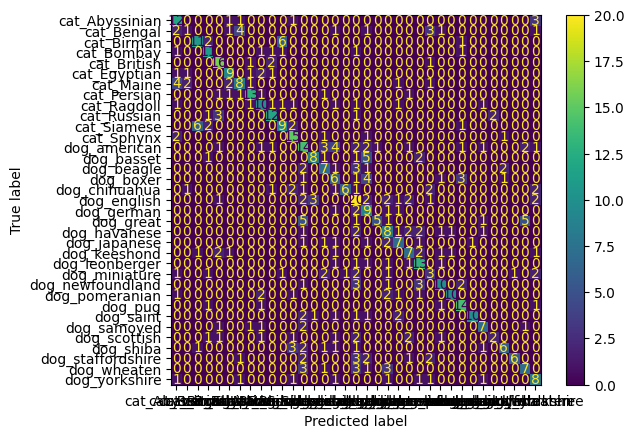

In [153]:
metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test.argmax(axis=1), model_multiclass.predict(x_test).argmax(axis=1)), display_labels=classes).plot()